In [1]:
from google.colab import drive
# drive.mount('/content/drive')
%cd /content/drive/MyDrive/UOC/TFM/

/content/drive/MyDrive/UOC/TFM


In [2]:
!pip install -qqq greykite

     |████████████████████████████████| 22.5 MB 1.4 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
     |████████████████████████████████| 316 kB 33.5 MB/s 
     |████████████████████████████████| 1.9 MB 53.4 MB/s 
     |████████████████████████████████| 9.4 MB 58.3 MB/s 
     |████████████████████████████████| 164 kB 63.8 MB/s 
     |████████████████████████████████| 9.7 MB 34.6 MB/s 
     |████████████████████████████████| 295 kB 51.4 MB/s 
     |████████████████████████████████| 965 kB 46.6 MB/s 
     |████████████████████████████████| 9.9 MB 28.3 MB/s 


In [3]:
!pip install -qqq smopy

In [2]:
from utils.data_functions import read_data, enhance_station_for_prediction, join_dfs_for_analysis
import utils.rnn_functions as rnn_fn
import utils.rf_functions as rf_fn
import utils.prophet_functions as ph_fn
import utils.silverkite_functions as sk_fn
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import smopy
import pickle
import os
import keras

# Carga de datos

## Lectura de datos

In [3]:
DATA_DIR = 'data'

outbounds, inbounds, stations, weather = read_data(DATA_DIR) #Esto tarda 2 mins
display(outbounds.head(3))
display(stations.head(3))
display(weather.head(3))

,day_hour,station_id,duration,trips
0,2020-12-01 04:00:00,384,320.0,1.0
1,2020-12-01 04:00:00,444,500.0,1.0
2,2020-12-01 04:00:00,493,414.0,1.0


,id,name,latitude,longitude
0,540,Lilleborgbanen,59.933632,10.769118
1,511,Henrik Ibsens gate,59.915088,10.722280
2,525,Myraløkka Øst,59.937205,10.760581


,temperature,wind_speed,weather_phenomena
time,,,
2020-01-01 00:00:00,2.1,6,no phenomena
2020-01-01 01:00:00,2.6,6,fog
2020-01-01 02:00:00,2.4,5,no phenomena


# Análisis descriptivo año 2021

- Análisis por:
  - [x] hora y día
  - [x] mes
  - [x] día
  - [x] hora
  - [x] dia de la semana
  - [x] temperaura
  - [x] fenómeno temporal

- Análisis de estaciones con más diferencia entre outbound e inbound por hora

- Añadir el clima y comparar con la duración de los viajes

- Mostrar en un mapa inbounds y outbounds de estaciones (opc)



## Añadir columnas relevantes

In [ ]:
analysis_df = join_dfs_for_analysis(
    outbounds_df=outbounds,
    inbounds_df=inbounds,
    weather_df=weather,
    start_date='2020-07-01',
    end_date='2022-06-30'
    )

analysis_df.head()

,day_hour,station_id,weekday,day,hour,day_of_month,month,year,temperature,wind_speed,weather_phenomena,duration_outbound,trips_outbound,duration_inbound,trips_inbound
0,2020-12-01 04:00:00,384.0,1,2020-12-01,4,1,12,2020,0.1,4,snow,320.0,1.0,0.0,0.0
1,2020-12-01 04:00:00,444.0,1,2020-12-01,4,1,12,2020,0.1,4,snow,500.0,1.0,0.0,0.0
2,2020-12-01 04:00:00,493.0,1,2020-12-01,4,1,12,2020,0.1,4,snow,414.0,1.0,0.0,0.0
3,2020-12-01 04:00:00,511.0,1,2020-12-01,4,1,12,2020,0.1,4,snow,828.0,1.0,0.0,0.0
4,2020-12-01 04:00:00,525.0,1,2020-12-01,4,1,12,2020,0.1,4,snow,846.0,1.0,0.0,0.0


## Gráficas

In [ ]:
def two_var_graphs(df, x, y, agg_fn='sum', kind='line'):

  df_filtered = df[[x,y]]
  df_grouped = df_filtered.groupby([x], as_index=False).agg({y: agg_fn})
  df_grouped.plot(x=x, y=y, figsize=(12,8), kind=kind)
  plt.show()

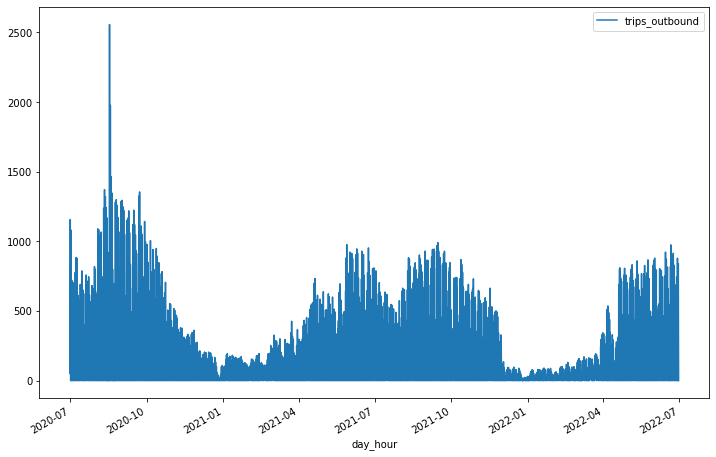

In [ ]:
two_var_graphs(analysis_df, 'day_hour', 'trips_outbound', 'sum')

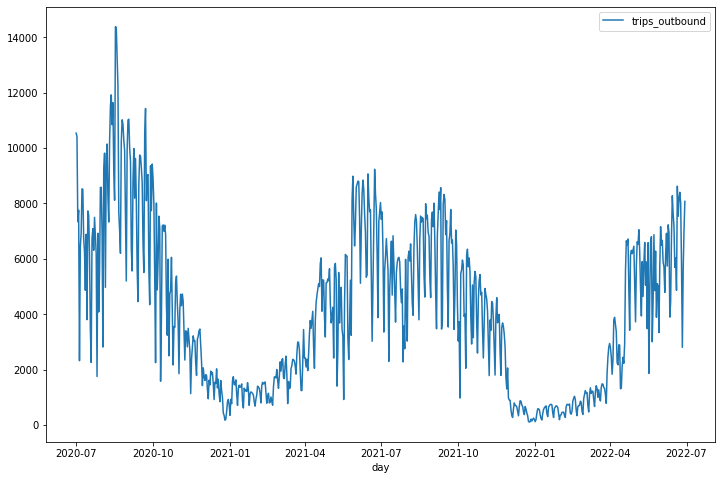

In [ ]:
two_var_graphs(analysis_df, 'day', 'trips_outbound', 'sum')

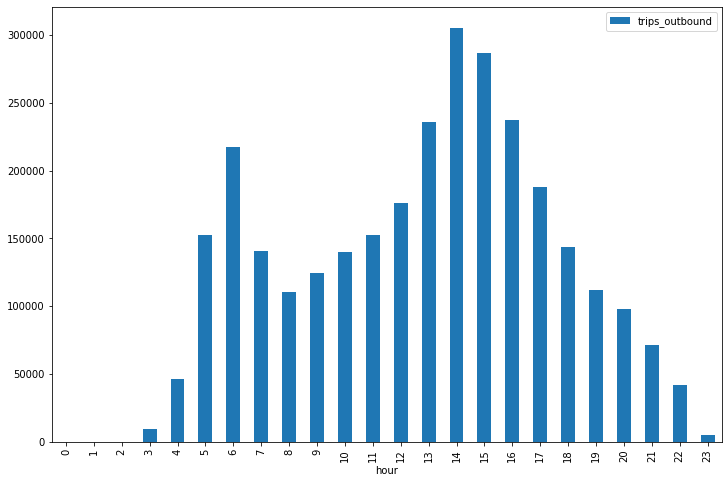

In [ ]:
two_var_graphs(analysis_df, 'hour', 'trips_outbound', 'sum', 'bar')

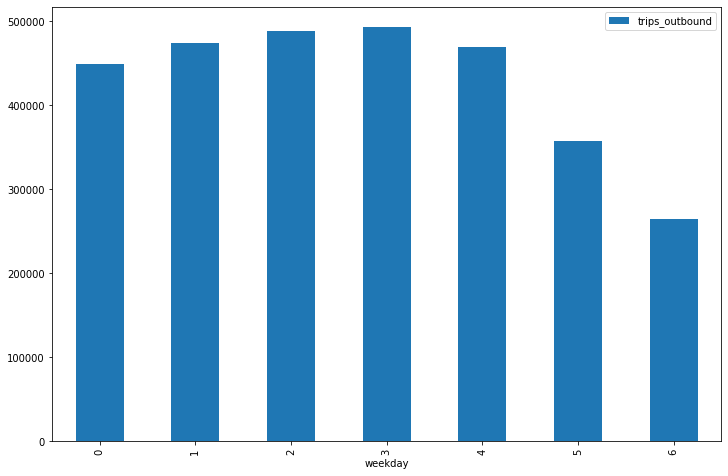

In [ ]:
two_var_graphs(analysis_df, 'weekday', 'trips_outbound', 'sum', 'bar')

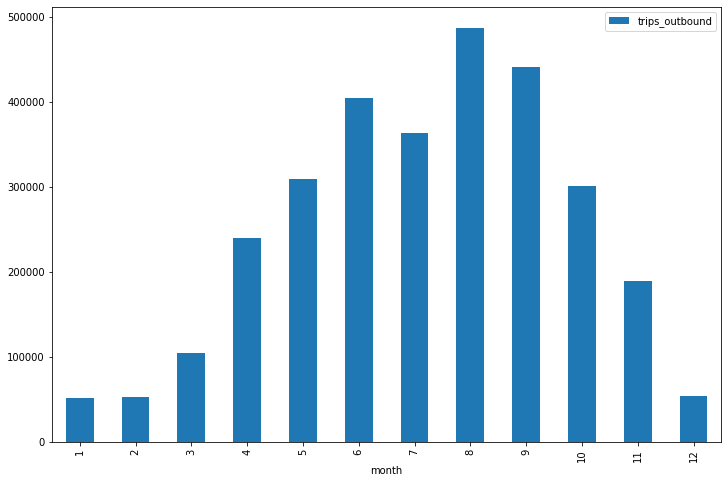

In [ ]:
two_var_graphs(analysis_df, 'month', 'trips_outbound', 'sum', 'bar')

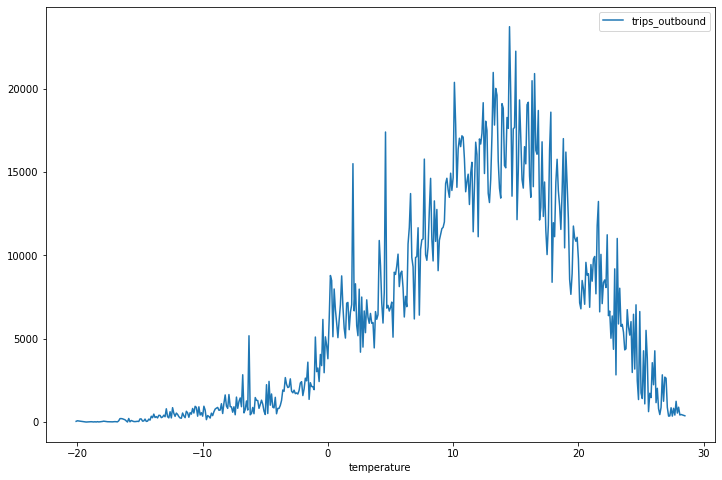

In [ ]:
two_var_graphs(analysis_df, 'temperature', 'trips_outbound', 'sum')

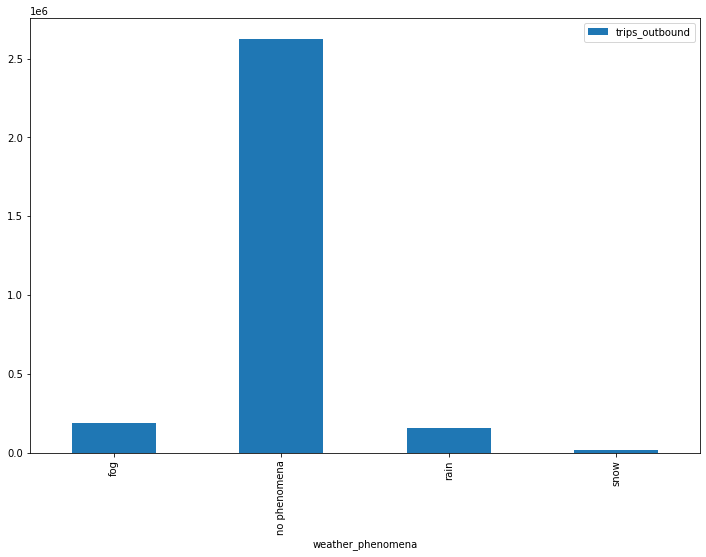

In [ ]:
two_var_graphs(analysis_df, 'weather_phenomena', 'trips_outbound', 'sum', 'bar')

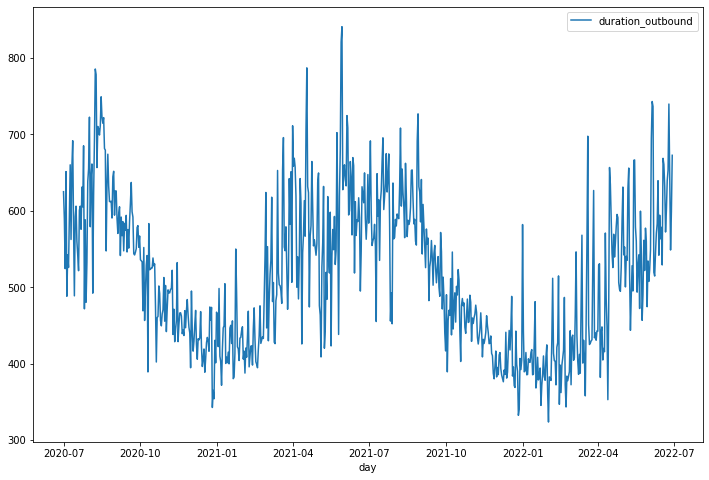

In [ ]:
two_var_graphs(analysis_df, 'day', 'duration_outbound', 'mean')

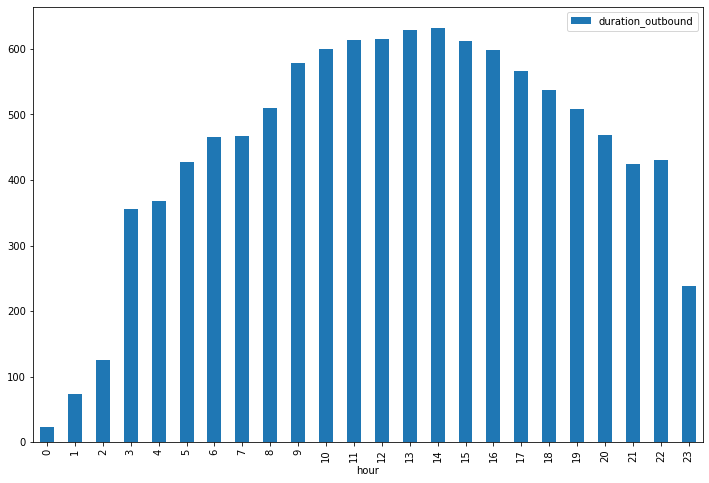

In [ ]:
two_var_graphs(analysis_df, 'hour', 'duration_outbound', 'mean', 'bar')

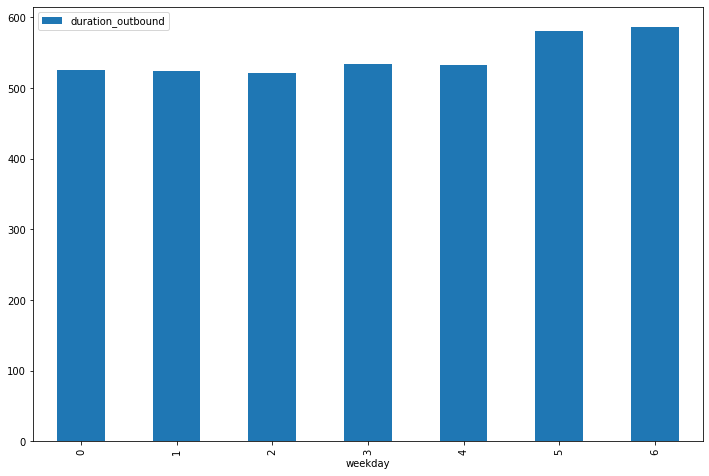

In [ ]:
two_var_graphs(analysis_df, 'weekday', 'duration_outbound', 'mean', 'bar')

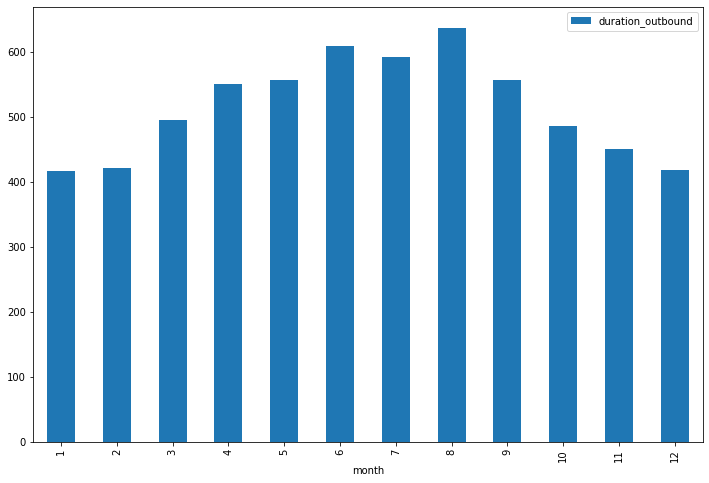

In [ ]:
two_var_graphs(analysis_df, 'month', 'duration_outbound', 'mean', 'bar')

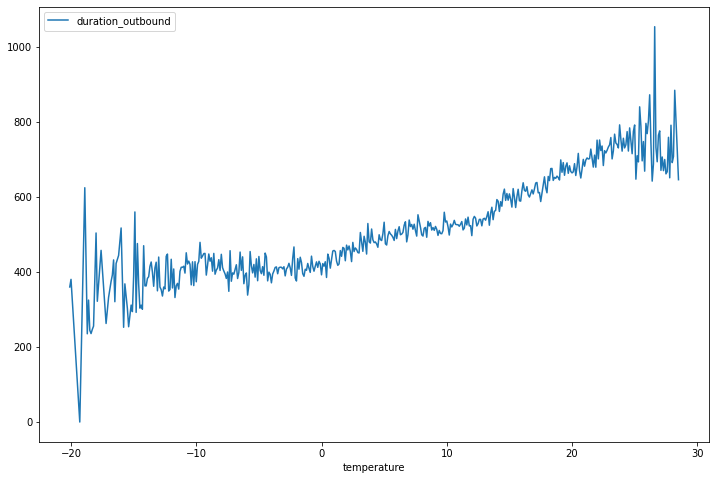

In [ ]:
two_var_graphs(analysis_df, 'temperature', 'duration_outbound', 'mean')

## Estaciones más especiales

In [ ]:
trips_by_station = analysis_df.groupby(['station_id']).agg({'trips_outbound':'sum', 'trips_inbound':'sum'})
trips_by_station['total_trips'] = trips_by_station['trips_outbound'] + trips_by_station['trips_inbound']
trips_by_station['diff_trips'] = trips_by_station['trips_outbound'] - trips_by_station['trips_inbound']
trips_by_station.head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
377.0,8848.0,8555.0,17403.0,293.0
378.0,7897.0,7843.0,15740.0,54.0
380.0,17026.0,10596.0,27622.0,6430.0
381.0,15609.0,18356.0,33965.0,-2747.0
382.0,9825.0,9718.0,19543.0,107.0


### Estación más transitada

Definimos como estación más transitada aquella en la que se dejan y se cogen más bicicletas.

In [ ]:
trips_by_station.sort_values(by='total_trips', ascending=False).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
551.0,39057.0,44785.0,83842.0,-5728.0
421.0,40835.0,40696.0,81531.0,139.0
398.0,39559.0,39622.0,79181.0,-63.0
489.0,28465.0,46487.0,74952.0,-18022.0
480.0,30870.0,38843.0,69713.0,-7973.0


### Estación menos transitada

In [ ]:
trips_by_station.sort_values(by='total_trips', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
2340.0,579.0,309.0,888.0,270.0
492.0,485.0,536.0,1021.0,-51.0
2347.0,498.0,543.0,1041.0,-45.0
2332.0,565.0,617.0,1182.0,-52.0
2339.0,615.0,700.0,1315.0,-85.0


### Estación más desbalanceada por exceso de entradas

In [ ]:
trips_by_station.sort_values(by='diff_trips', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
489.0,28465.0,46487.0,74952.0,-18022.0
495.0,12397.0,29323.0,41720.0,-16926.0
599.0,10244.0,26231.0,36475.0,-15987.0
494.0,24799.0,40605.0,65404.0,-15806.0
443.0,25815.0,41282.0,67097.0,-15467.0


### Estación más desbalanceadas por exceso de salidas

In [ ]:
trips_by_station.sort_values(by='diff_trips', ascending=False).head()

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
397.0,22901.0,10637.0,33538.0,12264.0
582.0,19835.0,9433.0,29268.0,10402.0
391.0,18073.0,8136.0,26209.0,9937.0
383.0,15568.0,6312.0,21880.0,9256.0
434.0,12281.0,3475.0,15756.0,8806.0


### Estación promedio

In [ ]:
def distance_to_mean(element, df):
  mean = df.mean()
  dist = 0
  for i in range(len(element)):
    dist += np.power(element[i] - mean[i], 2)
  
  return np.sqrt(dist)

In [ ]:
trips_by_station['distance_to_mean'] = trips_by_station.apply(lambda station: distance_to_mean(station, trips_by_station), axis=1)

In [ ]:
trips_by_station.sort_values(by='distance_to_mean', ascending=True).head()

,trips_outbound,trips_inbound,total_trips,diff_trips,distance_to_mean
station_id,,,,,
414.0,10826.0,10932.0,21758.0,-106.0,277.844105
457.0,11123.0,11135.0,22258.0,-12.0,367.017989
574.0,10558.0,11050.0,21608.0,-492.0,739.896270
624.0,11259.0,10620.0,21879.0,639.0,788.656401
744.0,11500.0,10467.0,21967.0,1033.0,1265.203565


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


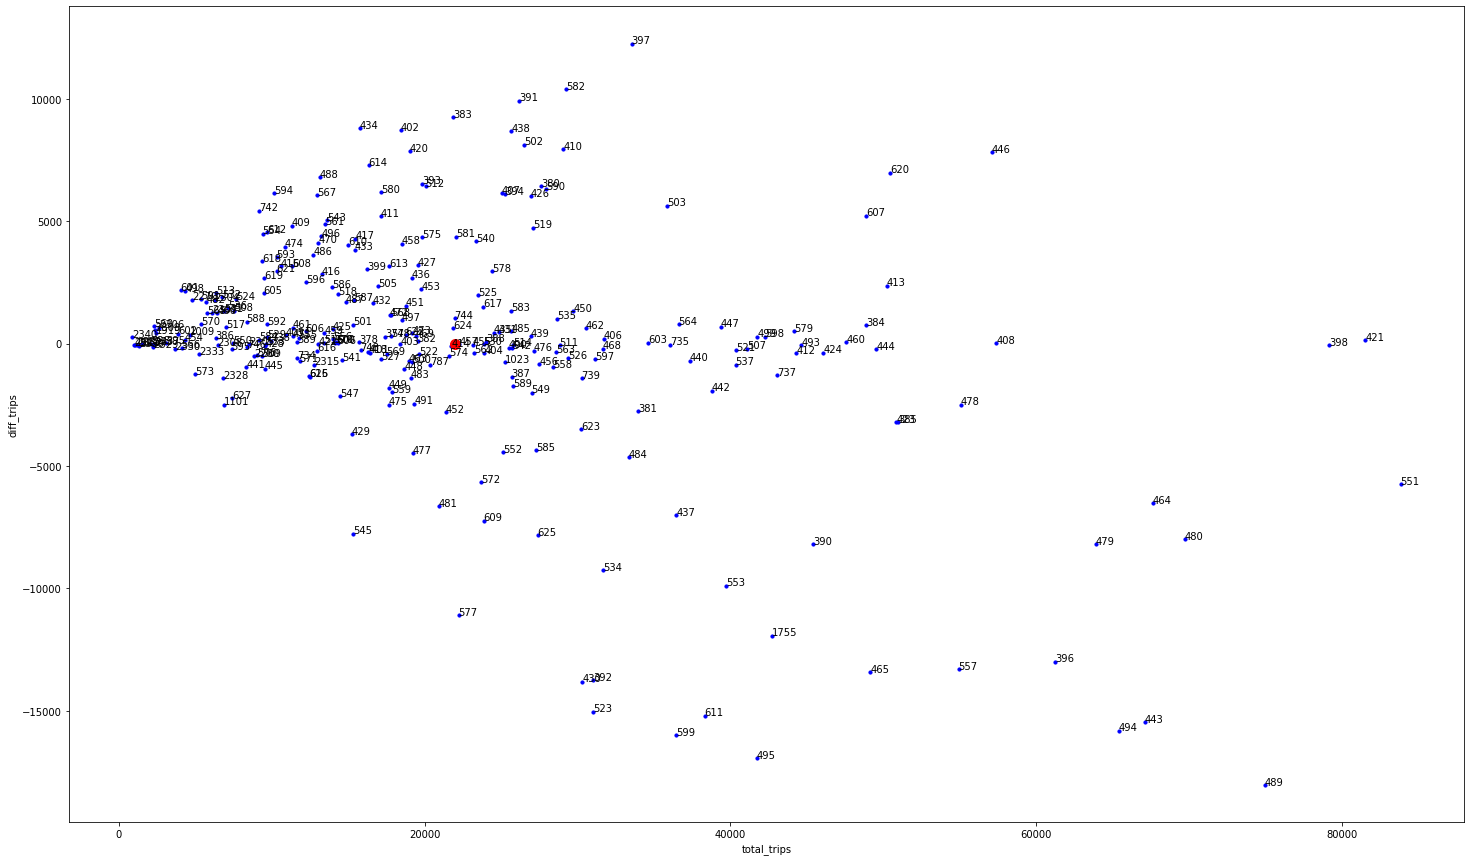

In [ ]:
ax = trips_by_station.plot.scatter(x='total_trips', y='diff_trips', c='Blue',s=10, figsize=(25, 15))
for i, txt in enumerate([int(i) for i in trips_by_station.index]):
   ax.annotate(txt, (trips_by_station.total_trips.iat[i]+0.05, trips_by_station.diff_trips.iat[i]), size=10)

ax.scatter(trips_by_station.mean()['total_trips'],trips_by_station.mean()['diff_trips'], c='Red', s=100)
plt.show()

In [ ]:
stations = stations.groupby(by=['id','name'], as_index=False).sum()

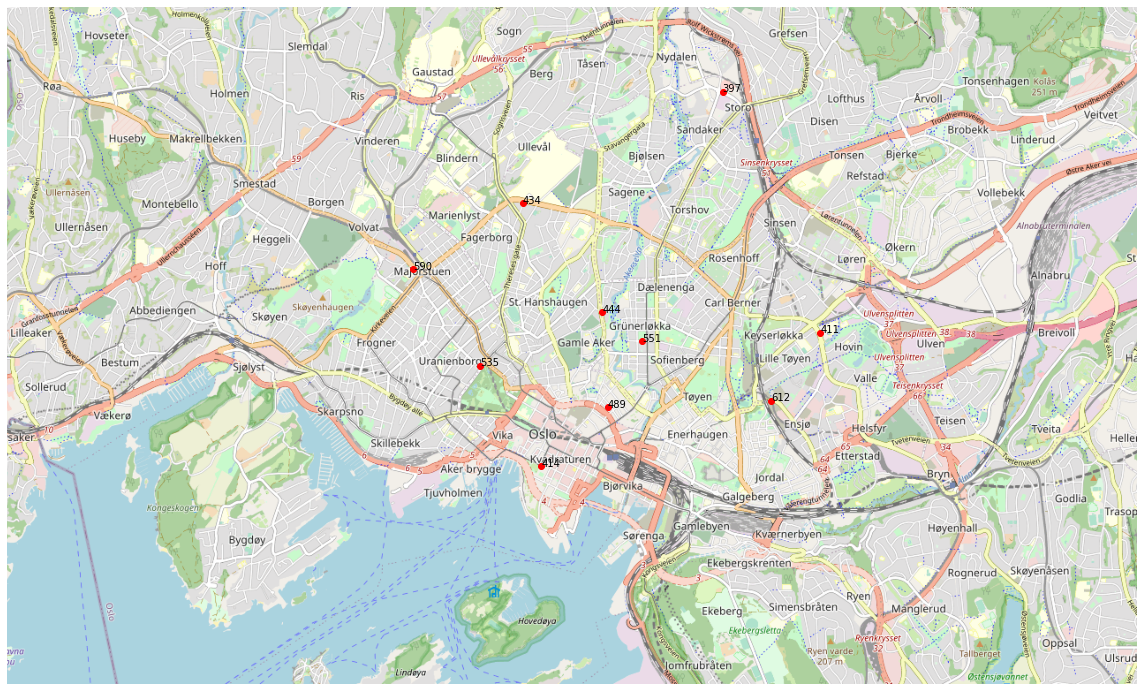

In [ ]:
map = smopy.Map(
    (59.892888,
     10.657508,
     59.945703,
     10.804925), z=13)
ax = map.show_mpl(figsize=(16, 12))

for index, row in stations.iterrows():
  if row.id in [414, 551, 397, 489, 434, 535, 590, 612, 411, 444]:
    x, y = map.to_pixels(row.latitude, row.longitude)
    ax.plot(x, y, 'or')
    ax.annotate(row.id, (x + 0.05, y), size=10)

In [ ]:
pred_stations = [414, 551, 397, 489, 434, 535, 590, 612, 411, 444]
trips_by_station.loc[pred_stations]

,trips_outbound,trips_inbound,total_trips,diff_trips
station_id,,,,
414,10826.0,10932.0,21758.0,-106.0
551,39057.0,44785.0,83842.0,-5728.0
397,22901.0,10637.0,33538.0,12264.0
489,28465.0,46487.0,74952.0,-18022.0
434,12281.0,3475.0,15756.0,8806.0
535,14850.0,13820.0,28670.0,1030.0
590,17118.0,10805.0,27923.0,6313.0
612,7127.0,2564.0,9691.0,4563.0
411,11187.0,5967.0,17154.0,5220.0


# Modelos

## Definición de los distintos modelos

In [ ]:
# fin de la cuarentena y buen tiempo
outbound_station = enhance_station_for_prediction(414, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
outbound_station.head()

,trips,day_of_month,month,year,hour,duration,weekday,temperature,wind_speed,weather_phenomena
day_hour,,,,,,,,,,
2020-07-01 00:00:00,0.0,1,7,2020,0,0.0,2,11.5,6,0
2020-07-01 01:00:00,0.0,1,7,2020,1,0.0,2,9.9,8,1
2020-07-01 02:00:00,0.0,1,7,2020,2,0.0,2,9.7,6,0
2020-07-01 03:00:00,0.0,1,7,2020,3,0.0,2,9.7,4,0
2020-07-01 04:00:00,0.0,1,7,2020,4,0.0,2,9.5,4,1


### LSTM

In [ ]:
n_hours = 3
n_features = 10

output_LSTM = rnn_fn.run_model(
    df=outbound_station,
    n_hours=n_hours,
    n_features=n_features,
    test_size=0.2,
    rnn_type='LSTM',
    units=10,
    optimizer='adam',
    epochs=50,
    batch_size=72,
    early_stopping=5,
    hyperparam_search=True
  )

110/110 [==============================] - 1s 2ms/step


In [ ]:
print('Test RMSE: %.3f' % output_LSTM['test_rmse'])
print('Test rounded RMSE: %.3f' % output_LSTM['test_rmse_rounded'])

Test RMSE: 0.951
Test rounded RMSE: 0.983


### GRU

In [ ]:
n_hours = 3
n_features = 10

output_GRU = rnn_fn.run_model(
    df=outbound_station,
    n_hours=n_hours,
    n_features=n_features,
    test_size=0.2,
    rnn_type='GRU',
    units=10,
    optimizer='adam',
    epochs=50,
    batch_size=72,
    early_stopping=5,
    hyperparam_search=True
  )

110/110 [==============================] - 1s 2ms/step


In [ ]:
print('Test RMSE: %.3f' % output_GRU['test_rmse'])
print('Test rounded RMSE: %.3f' % output_GRU['test_rmse_rounded'])

Test RMSE: 0.956
Test rounded RMSE: 0.966


### Random forest

In [ ]:
n_hours = 8
n_features = 10

output_rf = rf_fn.run_model(
    df=outbound_station, 
    n_hours=n_hours,
    n_features=n_features,
    test_size=0.2,
    n_estimators=1000,
    max_depth=10,
    max_features='sqrt', 
    hyperparam_search=True
  )

In [ ]:
print('Test RMSE: %.3f' % output_rf['test_rmse'])
print('Test rounded RMSE: %.3f' % output_rf['test_rmse_rounded'])

Test RMSE: 0.769
Test rounded RMSE: 0.800


### Prophet

In [ ]:
n_hours = 1
n_features = 10

output_ph = ph_fn.run_model(
    df=outbound_station, 
    n_hours=n_hours,
    n_features=n_features,
    test_size=0.2,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    hyperparam_search=True
  )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpddprol4i/lqg6sshq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpddprol4i/3tags1jx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28195', 'data', 'file=/tmp/tmpddprol4i/lqg6sshq.json', 'init=/tmp/tmpddprol4i/3tags1jx.json', 'output', 'file=/tmp/tmpddprol4i/prophet_modelj169yq2i/prophet_model-20221210204954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
print('Test RMSE: %.3f' % output_ph['test_rmse'])
print('Test rounded RMSE: %.3f' % output_ph['test_rmse_rounded'])

Test RMSE: 0.851
Test rounded RMSE: 0.874


### Silver kite

In [ ]:
n_hours = 3
n_features = 10

output_sk = sk_fn.run_model(
    df=outbound_station, 
    n_hours=n_hours,
    n_features=n_features,
    test_size=0.2,
    min_admissible_value=0,
    changepoint_method='auto',
    hyperparam_search=True
  )

/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

In [ ]:
print('Test RMSE: %.3f' % output_sk['test_rmse'])
print('Test rounded RMSE: %.3f' % output_sk['test_rmse_rounded'])

Test RMSE: 0.814
Test rounded RMSE: 0.837


## Búsqueda de hiperparámetros

In [ ]:
# Global params
N_FEATURES = 10
RUNS = 5

### LSTM

In [ ]:
# Hyperparams LSTM
n_hours = [1,2,4,8]
units = [10, 50, 100]
optimizer = ['adam', 'RMSprop']
batch_size = [64, 128]

In [ ]:
LSTM_hiperparams = pd.DataFrame(columns=['n_hours', 'units', 'optimizer', 'batch_size', 'rmse', 'rmse_rounded', 'time'])

for h in n_hours:
  for u in units:
    for o in optimizer:
      for b in batch_size:
        rmse=0
        rmse_rounded=0
        print(f'LSTM - n_hours:{h} units:{u} optimizer:{o} batch_size:{b}')
        start=time.time()
        for i in range(RUNS):
          output = rnn_fn.run_model(
              df=outbound_station,
              n_hours=h,
              n_features=N_FEATURES,
              test_size=0.2,
              rnn_type='LSTM',
              units=u,
              optimizer=o,
              epochs=25,
              batch_size=b,
              early_stopping=5,
              hyperparam_search=True
            )
        rmse += output['test_rmse']
        rmse_rounded += output['test_rmse_rounded']
        end=time.time()
        new_row = {'n_hours':h, 'units':u, 'optimizer':o, 'batch_size':b, 'rmse':rmse/RUNS, 'rmse_rounded':rmse_rounded/RUNS, 'time':(end-start)/RUNS}
        LSTM_hiperparams = LSTM_hiperparams.append(new_row, ignore_index=True)



In [ ]:
LSTM_hiperparams.to_csv('results/LSTM_hiperparams.csv', sep=',', index=False)

### GRU

In [ ]:
# Hyperparams GRU
n_hours = [1,2,4,8]
units = [10, 50, 100]
optimizer = ['adam', 'RMSprop']
batch_size = [64, 128]

In [ ]:
GRU_hiperparams = pd.DataFrame(columns=['n_hours', 'units', 'optimizer', 'batch_size', 'rmse', 'rmse_rounded', 'time'])

for h in n_hours:
  for u in units:
    for o in optimizer:
      for b in batch_size:
        rmse=0
        rmse_rounded=0
        print(f'GRU - n_hours:{h} units:{u} optimizer:{o} batch_size:{b}')
        start=time.time()
        for i in range(RUNS):
          output= rnn_fn.run_model(
              df=outbound_station,
              n_hours=h,
              n_features=N_FEATURES,
              test_size=0.2,
              rnn_type='GRU',
              units=u,
              optimizer=o,
              epochs=25,
              batch_size=b,
              early_stopping=5,
              hyperparam_search=True
            )
          rmse += output['test_rmse']
          rmse_rounded += output['test_rmse_rounded']
        end=time.time()
        new_row = {'n_hours':h, 'units':u, 'optimizer':o, 'batch_size':b, 'rmse':rmse/RUNS, 'rmse_rounded':rmse_rounded/RUNS, 'time':(end-start)/RUNS}
        GRU_hiperparams = GRU_hiperparams.append(new_row, ignore_index=True)

GRU - n_hours:1 units:10 optimizer:adam batch_size:64
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:10 optimizer:adam batch_size:128
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:10 optimizer:RMSprop batch_size:64
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:10 optimizer:RMSprop batch_size:128
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:50 optimizer:adam batch_size:64
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:50 optimizer:adam batch_size:128
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:50 optimizer:RMSprop batch_size:64
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:50 optimizer:RMSprop batch_size:128
110/110 [==============================] - 1s 2ms/step
GRU - n_hours:1 units:100 optimizer:adam batch_size:64
110/110 [==============================] - 1s 2ms/step
GR

In [ ]:
GRU_hiperparams.to_csv('results/GRU_hiperparams.csv', sep=',', index=False)

### Random Forest

In [ ]:
# Hyperparams Random Forest
n_hours = [1,2,4,8]
n_estimators = [100, 1000]
max_depth = [10, 30]
max_features = ['sqrt', None]

In [ ]:
rf_hiperparams = pd.DataFrame(columns=['n_hours', 'n_estimators', 'max_depth', 'max_features', 'rmse', 'rmse_rounded', 'time'])

for h in n_hours:
  for e in n_estimators:
    for d in max_depth:
      for f in max_features:
        rmse=0
        rmse_rounded=0
        print(f'RF - n_hours:{h} n_estimators:{e} max_depth:{d} max_features:{f}')
        start=time.time()
        for i in range(RUNS):
          output = rf_fn.run_model(
              df=outbound_station,
              n_hours=h,
              n_features=N_FEATURES,
              test_size=0.2,
              n_estimators=e,
              max_depth=d,
              max_features=f,
              hyperparam_search=True
            )
          rmse += output['test_rmse']
          rmse_rounded += output['test_rmse_rounded']
        end=time.time()
        new_row = {'n_hours':h, 'n_estimators':e, 'max_depth':d, 'max_features':f, 'rmse':rmse/RUNS, 'rmse_rounded':rmse_rounded/RUNS, 'time':(end-start)/RUNS}
        rf_hiperparams = rf_hiperparams.append(new_row, ignore_index=True)

RF - n_hours:1 n_estimators:100 max_depth:10 max_features:sqrt
RF - n_hours:1 n_estimators:100 max_depth:10 max_features:None
RF - n_hours:1 n_estimators:100 max_depth:30 max_features:sqrt
RF - n_hours:1 n_estimators:100 max_depth:30 max_features:None
RF - n_hours:1 n_estimators:1000 max_depth:10 max_features:sqrt
RF - n_hours:1 n_estimators:1000 max_depth:10 max_features:None
RF - n_hours:1 n_estimators:1000 max_depth:30 max_features:sqrt
RF - n_hours:1 n_estimators:1000 max_depth:30 max_features:None
RF - n_hours:2 n_estimators:100 max_depth:10 max_features:sqrt
RF - n_hours:2 n_estimators:100 max_depth:10 max_features:None
RF - n_hours:2 n_estimators:100 max_depth:30 max_features:sqrt
RF - n_hours:2 n_estimators:100 max_depth:30 max_features:None
RF - n_hours:2 n_estimators:1000 max_depth:10 max_features:sqrt
RF - n_hours:2 n_estimators:1000 max_depth:10 max_features:None
RF - n_hours:2 n_estimators:1000 max_depth:30 max_features:sqrt
RF - n_hours:2 n_estimators:1000 max_depth:30 ma

In [ ]:
rf_hiperparams.to_csv('results/rf_hiperparams.csv', sep=',', index=False)

### Prophet

In [ ]:
# Hyperparams Prophet
n_hours = [1,2,4,8]
changepoint_prior_scale = [0.001, 0.05, 0.1]
seasonality_prior_scale = [0.1, 1, 10]

In [ ]:
ph_hiperparams = pd.DataFrame(columns=['n_hours', 'changepoint_prior_scale', 'seasonality_prior_scale', 'rmse', 'rmse_rounded', 'time'])

for h in n_hours:
  for c in changepoint_prior_scale:
    for s in seasonality_prior_scale:
      rmse=0
      rmse_rounded=0
      print(f'Prophet - n_hours:{h} changepoint_prior_scale:{c} seasonality_prior_scale:{s}')
      start=time.time()
      for i in range(RUNS):
        output = ph_fn.run_model(
            df=outbound_station,
            n_hours=h,
            n_features=N_FEATURES,
            test_size=0.2,
            changepoint_prior_scale=c,
            seasonality_prior_scale=s,
            hyperparam_search=True
          )
        rmse += output['test_rmse']
        rmse_rounded += output['test_rmse_rounded']
      end=time.time()
      new_row = {'n_hours':h, 'changepoint_prior_scale':c, 'seasonality_prior_scale':s, 'rmse':rmse/RUNS, 'rmse_rounded':rmse_rounded/RUNS, 'time':(end-start)/RUNS}
      ph_hiperparams = ph_hiperparams.append(new_row, ignore_index=True)

Prophet - n_hours:1 changepoint_prior_scale:0.001 seasonality_prior_scale:0.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/uhpr0nbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/g0r128b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41525', 'data', 'file=/tmp/tmpq0wgnjgf/uhpr0nbf.json', 'init=/tmp/tmpq0wgnjgf/g0r128b0.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model84hnvfte/prophet_model-20221211110459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:04:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:1 changepoint_prior_scale:0.001 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/2k66j05v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43088', 'data', 'file=/tmp/tmpq0wgnjgf/zarqp4hu.json', 'init=/tmp/tmpq0wgnjgf/2k66j05v.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelzcu6w6_g/prophet_model-20221211110516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/xnnu4bg5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/e3pnjwx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.001 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/j8fze8vk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98247', 'data', 'file=/tmp/tmpq0wgnjgf/fxet1sq1.json', 'init=/tmp/tmpq0wgnjgf/j8fze8vk.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelc2ynacyv/prophet_model-20221211110534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/z8ca1_9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/2lif8gxd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.05 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/58ai22ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45610', 'data', 'file=/tmp/tmpq0wgnjgf/iihnxww3.json', 'init=/tmp/tmpq0wgnjgf/58ai22ns.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelnl214pss/prophet_model-20221211110552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/7mfq8eaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/yy49wwtz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.05 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/et7h3hgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79634', 'data', 'file=/tmp/tmpq0wgnjgf/9vgqj750.json', 'init=/tmp/tmpq0wgnjgf/et7h3hgk.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model6zssgk81/prophet_model-20221211110623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/wnkpmn8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/36t_yy5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.05 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/03hw2zzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69196', 'data', 'file=/tmp/tmpq0wgnjgf/3awkjaoy.json', 'init=/tmp/tmpq0wgnjgf/03hw2zzm.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modeluyqb8bq2/prophet_model-20221211110645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ptf22boz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/iv9wa0ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.1 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/9onj1qgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10041', 'data', 'file=/tmp/tmpq0wgnjgf/aponsi6h.json', 'init=/tmp/tmpq0wgnjgf/9onj1qgg.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modellhakhzh7/prophet_model-20221211110708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:07:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:07:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/vub8vc0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/5co3z9gz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:1 changepoint_prior_scale:0.1 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/c_c4s1cw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2493', 'data', 'file=/tmp/tmpq0wgnjgf/wxsjwpn1.json', 'init=/tmp/tmpq0wgnjgf/c_c4s1cw.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelhezagj2d/prophet_model-20221211110747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:07:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/mfze1cvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/0opmjknp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

Prophet - n_hours:1 changepoint_prior_scale:0.1 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/k72kfrek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69855', 'data', 'file=/tmp/tmpq0wgnjgf/ul3u4wog.json', 'init=/tmp/tmpq0wgnjgf/k72kfrek.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model5msyip5o/prophet_model-20221211110833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:08:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:08:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/jgv8v3np.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/4jmaa9kv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:2 changepoint_prior_scale:0.001 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/jab8rh3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35501', 'data', 'file=/tmp/tmpq0wgnjgf/9r8qrw2g.json', 'init=/tmp/tmpq0wgnjgf/jab8rh3d.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelulnolj9l/prophet_model-20221211110910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/4digpo9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/q1mfzmsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:2 changepoint_prior_scale:0.001 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/7ktm5d0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99360', 'data', 'file=/tmp/tmpq0wgnjgf/8l2myeof.json', 'init=/tmp/tmpq0wgnjgf/7ktm5d0q.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modeljtyg4or4/prophet_model-20221211110928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/az45b_to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/9t5qkneg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:2 changepoint_prior_scale:0.001 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/1c8seg9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16941', 'data', 'file=/tmp/tmpq0wgnjgf/2ezyzs6i.json', 'init=/tmp/tmpq0wgnjgf/1c8seg9p.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model0x5_q7_5/prophet_model-20221211110947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/5np9fm5i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/tfo_kd8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:2 changepoint_prior_scale:0.05 seasonality_prior_scale:0.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ixs9ht0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/3h8obgdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58466', 'data', 'file=/tmp/tmpq0wgnjgf/ixs9ht0i.json', 'init=/tmp/tmpq0wgnjgf/3h8obgdv.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelzsfcgdt8/prophet_model-20221211111015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:2 changepoint_prior_scale:0.05 seasonality_prior_scale:1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/_i170qux.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/muwyvq4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15578', 'data', 'file=/tmp/tmpq0wgnjgf/_i170qux.json', 'init=/tmp/tmpq0wgnjgf/muwyvq4u.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model2cwu_542/prophet_model-20221211111039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:2 changepoint_prior_scale:0.05 seasonality_prior_scale:10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/nd47peq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/1sa01qa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14490', 'data', 'file=/tmp/tmpq0wgnjgf/nd47peq3.json', 'init=/tmp/tmpq0wgnjgf/1sa01qa7.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelc203e9td/prophet_model-20221211111109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:2 changepoint_prior_scale:0.1 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/643anzak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/sphv4mvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85773', 'data', 'file=/tmp/tmpq0wgnjgf/643anzak.json', 'init=/tmp/tmpq0wgnjgf/sphv4mvb.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modeli748nizc/prophet_model-20221211111138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:11:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:11:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/23_d94kb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/r4ydkf0x.json
DEBUG:cmdstanpy

Prophet - n_hours:2 changepoint_prior_scale:0.1 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/sw7lo2y9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73960', 'data', 'file=/tmp/tmpq0wgnjgf/va_gl5t6.json', 'init=/tmp/tmpq0wgnjgf/sw7lo2y9.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelc_yyazwv/prophet_model-20221211111225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/s8q_nlng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/nlyxgj48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:2 changepoint_prior_scale:0.1 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/q6ff4sd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96933', 'data', 'file=/tmp/tmpq0wgnjgf/5pxviao2.json', 'init=/tmp/tmpq0wgnjgf/q6ff4sd5.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model9o8gxj28/prophet_model-20221211111324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ms_nlsdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/3o4svlog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

Prophet - n_hours:4 changepoint_prior_scale:0.001 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/_kvy3j59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/j5trmcqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25114', 'data', 'file=/tmp/tmpq0wgnjgf/_kvy3j59.json', 'init=/tmp/tmpq0wgnjgf/j5trmcqh.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model8talt7y7/prophet_model-20221211111408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/4db_ujb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/0vv28b4g.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.001 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/h81feadx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/145ogm4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62194', 'data', 'file=/tmp/tmpq0wgnjgf/h81feadx.json', 'init=/tmp/tmpq0wgnjgf/145ogm4s.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelwaytj1uz/prophet_model-20221211111432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:14:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/uuo4tqv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/d3osxsuz.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.001 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/_y9044sz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/j5jj_v8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76552', 'data', 'file=/tmp/tmpq0wgnjgf/_y9044sz.json', 'init=/tmp/tmpq0wgnjgf/j5jj_v8s.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model9ih799bz/prophet_model-20221211111453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/n8p55z9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ov8nazn5.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.05 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/83uqxpe1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/33b8phzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83591', 'data', 'file=/tmp/tmpq0wgnjgf/83uqxpe1.json', 'init=/tmp/tmpq0wgnjgf/33b8phzv.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelq0_8saer/prophet_model-20221211111516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/38skrnjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/7qn4hkn5.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.05 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/55tnzdtd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/w6y5kqj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=201', 'data', 'file=/tmp/tmpq0wgnjgf/55tnzdtd.json', 'init=/tmp/tmpq0wgnjgf/w6y5kqj7.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model3xln6u3y/prophet_model-20221211111550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:15:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/3zf052y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/8z5evl0u.json
DEBUG:cmdstanpy:i

Prophet - n_hours:4 changepoint_prior_scale:0.05 seasonality_prior_scale:10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/r2q37r01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/rqupfp6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93176', 'data', 'file=/tmp/tmpq0wgnjgf/r2q37r01.json', 'init=/tmp/tmpq0wgnjgf/rqupfp6e.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelhmydegzg/prophet_model-20221211111636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:16:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:4 changepoint_prior_scale:0.1 seasonality_prior_scale:0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/nl6b7uav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/6ae5ppde.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53290', 'data', 'file=/tmp/tmpq0wgnjgf/nl6b7uav.json', 'init=/tmp/tmpq0wgnjgf/6ae5ppde.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model1ghbq6e6/prophet_model-20221211111711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/q9ybankh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/yn6pg8fg.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.1 seasonality_prior_scale:1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/3dz4ml0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/57flatm4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60356', 'data', 'file=/tmp/tmpq0wgnjgf/3dz4ml0n.json', 'init=/tmp/tmpq0wgnjgf/57flatm4.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model47b5fqcw/prophet_model-20221211111807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/5br9647t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/gikioe51.json
DEBUG:cmdstanpy

Prophet - n_hours:4 changepoint_prior_scale:0.1 seasonality_prior_scale:10


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/dg370uz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/643ac_4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49130', 'data', 'file=/tmp/tmpq0wgnjgf/dg370uz0.json', 'init=/tmp/tmpq0wgnjgf/643ac_4c.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modeliq40qle4/prophet_model-20221211111907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:19:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/9r62mxvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/kgig2wbe.json
DEBUG:cmdstanpy

Prophet - n_hours:8 changepoint_prior_scale:0.001 seasonality_prior_scale:0.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/de4sy3no.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/j5x_78et.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53899', 'data', 'file=/tmp/tmpq0wgnjgf/de4sy3no.json', 'init=/tmp/tmpq0wgnjgf/j5x_78et.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelci8ke37t/prophet_model-20221211112022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.001 seasonality_prior_scale:1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/e5_z0bay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ebgltoix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74069', 'data', 'file=/tmp/tmpq0wgnjgf/e5_z0bay.json', 'init=/tmp/tmpq0wgnjgf/ebgltoix.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modeld7tejgu0/prophet_model-20221211112054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.001 seasonality_prior_scale:10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/64l_az75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/n3b9i3b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23140', 'data', 'file=/tmp/tmpq0wgnjgf/64l_az75.json', 'init=/tmp/tmpq0wgnjgf/n3b9i3b4.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelrwacmevh/prophet_model-20221211112125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.05 seasonality_prior_scale:0.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/rnpwiu_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/58noglbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88860', 'data', 'file=/tmp/tmpq0wgnjgf/rnpwiu_p.json', 'init=/tmp/tmpq0wgnjgf/58noglbb.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model1z3csg9a/prophet_model-20221211112211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.05 seasonality_prior_scale:1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/m9n9cook.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/90_fpvm5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33894', 'data', 'file=/tmp/tmpq0wgnjgf/m9n9cook.json', 'init=/tmp/tmpq0wgnjgf/90_fpvm5.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modellf1hdaso/prophet_model-20221211112325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.05 seasonality_prior_scale:10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/2bnize7h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/yaesel15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3496', 'data', 'file=/tmp/tmpq0wgnjgf/2bnize7h.json', 'init=/tmp/tmpq0wgnjgf/yaesel15.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelx3o7piyy/prophet_model-20221211112440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:24:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:24:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Prophet - n_hours:8 changepoint_prior_scale:0.1 seasonality_prior_scale:0.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/kw_s9egr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/ldsdwq4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32391', 'data', 'file=/tmp/tmpq0wgnjgf/kw_s9egr.json', 'init=/tmp/tmpq0wgnjgf/ldsdwq4x.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_model_dzivqxv/prophet_model-20221211112552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.1 seasonality_prior_scale:1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/3u66frye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/0jz133d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91049', 'data', 'file=/tmp/tmpq0wgnjgf/3u66frye.json', 'init=/tmp/tmpq0wgnjgf/0jz133d7.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelae61rfwe/prophet_model-20221211112747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:27:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:28:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tm

Prophet - n_hours:8 changepoint_prior_scale:0.1 seasonality_prior_scale:10


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/827cphn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq0wgnjgf/4ivucnjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9565', 'data', 'file=/tmp/tmpq0wgnjgf/827cphn8.json', 'init=/tmp/tmpq0wgnjgf/4ivucnjo.json', 'output', 'file=/tmp/tmpq0wgnjgf/prophet_modelwc3r7g7x/prophet_model-20221211112932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

In [ ]:
ph_hiperparams.to_csv('results/ph_hiperparams.csv', sep=',', index=False)

### Silverkite

In [ ]:
# Hyperparams Silverkite
n_hours = [1,2,4,8]
min_admissible_value = [0, None]
changepoint_method = ['auto', None]

In [ ]:
sk_hiperparams = pd.DataFrame(columns=['n_hours', 'min_admissible_value', 'changepoint_method', 'rmse', 'rmse_rounded', 'time'])

for h in n_hours:
  for v in min_admissible_value:
    for c in changepoint_method:
      rmse=0
      rmse_rounded=0
      print(f'Silverkite - n_hours:{h} min_admissible_value:{v} changepoint_method:{c}')
      start=time.time()
      for i in range(RUNS):
        output = sk_fn.run_model(
            df=outbound_station,
            n_hours=h,
            n_features=N_FEATURES,
            test_size=0.2,
            min_admissible_value=v,
            changepoint_method=c,
            hyperparam_search=True
          )
        rmse += output['test_rmse']
        rmse_rounded += output['test_rmse_rounded']
      end=time.time()
      new_row = {'n_hours':h, 'min_admissible_value':v, 'changepoint_method':c, 'rmse':rmse/RUNS, 'rmse_rounded':rmse_rounded/RUNS, 'time':(end-start)/RUNS}
      sk_hiperparams = sk_hiperparams.append(new_row, ignore_index=True)

Silverkite - n_hours:1 min_admissible_value:0 changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:1 min_admissible_value:0 changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:1 min_admissible_value:None changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarn

Silverkite - n_hours:1 min_admissible_value:None changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarn

Silverkite - n_hours:2 min_admissible_value:0 changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:2 min_admissible_value:0 changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:2 min_admissible_value:None changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

Silverkite - n_hours:2 min_admissible_value:None changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

Silverkite - n_hours:4 min_admissible_value:0 changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:4 min_admissible_value:0 changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:4 min_admissible_value:None changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

Silverkite - n_hours:4 min_admissible_value:None changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

Silverkite - n_hours:8 min_admissible_value:0 changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:8 min_admissible_value:0 changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:456: UserWarning: denominator contains 0. sMAPE is undefined.
  warnings.warn("denominator contains 0. sMAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:4

Silverkite - n_hours:8 min_admissible_value:None changepoint_method:auto


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

Silverkite - n_hours:8 min_admissible_value:None changepoint_method:None


/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:418: UserWarning: y_true contains 0. MAPE is undefined.
  warnings.warn("y_true contains 0. MAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:435: UserWarning: y_true contains 0. MedAPE is undefined.
  warnings.warn("y_true contains 0. MedAPE is undefined.")
/usr/local/lib/python3.8/dist-packages/greykite/common/evaluation.py:459: UserWarning: denominator contains very small values. sMAPE is likely highly volatile.
  warnings.warn("denominator contains very small values. sMAPE is likely highly volatile.")
/usr/local/l

In [ ]:
sk_hiperparams.to_csv('results/sk_hiperparams.csv', sep=',', index=False)

## Selección y entrenamiento del mejor modelo

In [5]:
STATIONS_FOR_PREDICTION = [414, 551, 397, 489, 434, 535, 590, 612, 411, 444]
N_FEATURES = 10

In [ ]:
def save_training(training_dict, model_name, is_keras=False):
  if not os.path.exists(f'training/{model_name}'):
    os.mkdir(f'training/{model_name}')
  for station in STATIONS_FOR_PREDICTION:
    if is_keras:
      training_dict[station]['outbound']['history'] = training_dict[station]['outbound']['history'].history
      training_dict[station]['inbound']['history'] = training_dict[station]['inbound']['history'].history
      training_dict[station]['outbound']['model'].save(f'training/{model_name}/models/{station}_outbound_model.h5')
      training_dict[station]['inbound']['model'].save(f'training/{model_name}/models/{station}_inbound_model.h5')

      training_dict[station]['outbound'].pop('model')
      training_dict[station]['inbound'].pop('model')

    if model_name == 'silverkite':
      training_dict[station]['outbound'].pop('model')
      training_dict[station]['inbound'].pop('model')
      training_dict[station]['outbound'].pop('history')
      training_dict[station]['inbound'].pop('history')

  with open(f"training/{model_name}/output.pkl","wb") as f:
    pickle.dump(training_dict, f)

### LSTM

In [ ]:
results_LSTM = pd.read_csv('results/LSTM_hiperparams.csv', sep=',')
results_LSTM.sort_values(by=['rmse_rounded', 'rmse'],ascending=True).head()

,n_hours,units,optimizer,batch_size,rmse,rmse_rounded,time
46,8,100,RMSprop,64,0.816051,0.846601,32.157543
44,8,100,adam,64,0.833035,0.862308,36.517648
40,8,50,adam,64,0.860038,0.880171,35.448532
42,8,50,RMSprop,64,0.864403,0.885346,34.142188
32,4,100,adam,64,0.881367,0.898027,41.827367


In [ ]:
LSTM_config={
    'n_hours': 8,
    'units': 100,
    'optimizer': 'RMSprop',
    'batch_size': 64
}

In [ ]:
LSTM_training = {}

for station in STATIONS_FOR_PREDICTION:
  LSTM_training[station]={}
  outbound_station = enhance_station_for_prediction(station, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  inbound_station = enhance_station_for_prediction(station, inbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  LSTM_output_outbound = rnn_fn.run_model(
                df=outbound_station,
                n_hours=LSTM_config['n_hours'],
                n_features=N_FEATURES,
                test_size=0.2,
                rnn_type='LSTM',
                units=LSTM_config['units'],
                optimizer=LSTM_config['optimizer'],
                epochs=25,
                batch_size=LSTM_config['batch_size'],
                early_stopping=5,
                hyperparam_search=False
              )
  LSTM_output_inbound = rnn_fn.run_model(
                df=inbound_station,
                n_hours=LSTM_config['n_hours'],
                n_features=N_FEATURES,
                test_size=0.2,
                rnn_type='LSTM',
                units=LSTM_config['units'],
                optimizer=LSTM_config['optimizer'],
                epochs=25,
                batch_size=LSTM_config['batch_size'],
                early_stopping=5,
                hyperparam_search=False
              )
  LSTM_training[station]['outbound'] = LSTM_output_outbound
  LSTM_training[station]['inbound'] = LSTM_output_inbound


110/110 [==============================] - 1s 3ms/step


In [ ]:
save_training(LSTM_training, 'LSTM', is_keras=True)

### GRU

In [ ]:
results_GRU = pd.read_csv('results/GRU_hiperparams.csv', sep=',')
results_GRU.sort_values(by=['rmse_rounded', 'rmse'],ascending=True).head()

In [ ]:
GRU_config={
    'n_hours': 8,
    'units': 100,
    'optimizer': 'RMSprop',
    'batch_size': 64
}

In [ ]:
GRU_training = {}

for station in STATIONS_FOR_PREDICTION:
  GRU_training[station]={}
  outbound_station = enhance_station_for_prediction(station, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  inbound_station = enhance_station_for_prediction(station, inbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  GRU_output_outbound = rnn_fn.run_model(
                df=outbound_station,
                n_hours=GRU_config['n_hours'],
                n_features=N_FEATURES,
                test_size=0.2,
                rnn_type='GRU',
                units=GRU_config['units'],
                optimizer=GRU_config['optimizer'],
                epochs=25,
                batch_size=GRU_config['batch_size'],
                early_stopping=5,
                hyperparam_search=False
              )
  GRU_output_inbound = rnn_fn.run_model(
                df=inbound_station,
                n_hours=GRU_config['n_hours'],
                n_features=N_FEATURES,
                test_size=0.2,
                rnn_type='GRU',
                units=GRU_config['units'],
                optimizer=GRU_config['optimizer'],
                epochs=25,
                batch_size=GRU_config['batch_size'],
                early_stopping=5,
                hyperparam_search=False
              )
  GRU_training[station]['outbound'] = GRU_output_outbound
  GRU_training[station]['inbound'] = GRU_output_inbound

In [ ]:
save_training(GRU_training, 'GRU', is_keras=True)

### Random forest

In [ ]:
results_rf = pd.read_csv('results/rf_hiperparams.csv', sep=',')
results_rf.sort_values(by=['rmse_rounded', 'rmse'], ascending=True).head()

,n_hours,n_estimators,max_depth,max_features,rmse,rmse_rounded,time
24,8.0,100.0,10.0,sqrt,0.768746,0.799772,1.375769
28,8.0,1000.0,10.0,sqrt,0.769294,0.800128,13.523326
21,4.0,1000.0,10.0,NaN,0.779549,0.804994,54.048936
16,4.0,100.0,10.0,sqrt,0.777457,0.805703,1.126676
13,2.0,1000.0,10.0,NaN,0.777475,0.806474,28.378125


In [ ]:
rf_config={
    'n_hours': 8,
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt'
}

In [ ]:
rf_training = {}

for station in STATIONS_FOR_PREDICTION:
  rf_training[station]={}
  outbound_station = enhance_station_for_prediction(station, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  inbound_station = enhance_station_for_prediction(station, inbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  rf_output_outbound = rf_fn.run_model(
              df=outbound_station,
              n_hours=rf_config['n_hours'],
              n_features=N_FEATURES,
              test_size=0.2,
              n_estimators=rf_config['n_estimators'],
              max_depth=rf_config['max_depth'],
              max_features=rf_config['max_features'],
              hyperparam_search=False
            )
  rf_output_inbound = rf_fn.run_model(
              df=inbound_station,
              n_hours=rf_config['n_hours'],
              n_features=N_FEATURES,
              test_size=0.2,
              n_estimators=rf_config['n_estimators'],
              max_depth=rf_config['max_depth'],
              max_features=rf_config['max_features'],
              hyperparam_search=False
            )
  rf_training[station]['outbound'] = rf_output_outbound
  rf_training[station]['inbound'] = rf_output_inbound

In [ ]:
save_training(rf_training, 'random_forest', is_keras=False)

### Prophet

In [ ]:
results_ph = pd.read_csv('results/ph_hiperparams.csv', sep=',')
results_ph.sort_values(by=['rmse_rounded', 'rmse'], ascending=True).head()

,n_hours,changepoint_prior_scale,seasonality_prior_scale,rmse,rmse_rounded,time
28,8.0,0.001,1.0,0.833865,0.853320,6.253483
29,8.0,0.001,10.0,0.834315,0.853655,9.146551
27,8.0,0.001,0.1,0.834515,0.854658,6.395276
16,2.0,0.100,1.0,0.837479,0.855248,11.669731
18,4.0,0.001,0.1,0.836168,0.857537,4.832805


In [ ]:
ph_config={
    'n_hours': 8,
    'changepoint_prior_scale': 0.001,
    'seasonality_prior_scale': 1.0,
}

In [ ]:
ph_training = {}

for station in STATIONS_FOR_PREDICTION:
  ph_training[station]={}
  outbound_station = enhance_station_for_prediction(station, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  inbound_station = enhance_station_for_prediction(station, inbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  ph_output_outbound = ph_fn.run_model(
            df=outbound_station,
            n_hours=ph_config['n_hours'],
            n_features=N_FEATURES,
            test_size=0.2,
            changepoint_prior_scale=ph_config['changepoint_prior_scale'],
            seasonality_prior_scale=ph_config['seasonality_prior_scale'],
            hyperparam_search=False
          )
  ph_output_inbound = ph_fn.run_model(
            df=inbound_station,
            n_hours=ph_config['n_hours'],
            n_features=N_FEATURES,
            test_size=0.2,
            changepoint_prior_scale=ph_config['changepoint_prior_scale'],
            seasonality_prior_scale=ph_config['seasonality_prior_scale'],
            hyperparam_search=False
          )
  ph_training[station]['outbound'] = ph_output_outbound
  ph_training[station]['inbound'] = ph_output_inbound

In [ ]:
save_training(ph_training, 'prophet', is_keras=False)

### Silver kite

In [ ]:
results_sk = pd.read_csv('results/sk_hiperparams.csv', sep=',')
results_sk.sort_values(by=['rmse_rounded', 'rmse'], ascending=True).head()

,n_hours,min_admissible_value,changepoint_method,rmse,rmse_rounded,time
4,2.0,0.0,auto,0.813515,0.836182,5.124507
5,2.0,0.0,NaN,0.813515,0.836182,3.088859
12,8.0,0.0,auto,0.807971,0.837445,5.304861
13,8.0,0.0,NaN,0.807971,0.837445,3.207425
0,1.0,0.0,auto,0.814597,0.838568,3.886694


In [ ]:
sk_config={
    'n_hours': 2,
    'min_admissible_value': 0.0,
    'changepoint_method': None,
}

In [ ]:
sk_training = {}

for station in STATIONS_FOR_PREDICTION:
  sk_training[station]={}
  outbound_station = enhance_station_for_prediction(station, outbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  inbound_station = enhance_station_for_prediction(station, inbounds, weather, start_date='2020-07-01', end_date='2022-06-30')
  sk_output_outbound = sk_fn.run_model(
            df=outbound_station,
            n_hours=sk_config['n_hours'],
            n_features=N_FEATURES,
            test_size=0.2,
            min_admissible_value=sk_config['min_admissible_value'],
            changepoint_method=sk_config['changepoint_method'],
            hyperparam_search=False
          )
  sk_output_inbound = sk_fn.run_model(
            df=inbound_station,
            n_hours=sk_config['n_hours'],
            n_features=N_FEATURES,
            test_size=0.2,
            min_admissible_value=sk_config['min_admissible_value'],
            changepoint_method=sk_config['changepoint_method'],
            hyperparam_search=False
          )
  sk_training[station]['outbound'] = sk_output_outbound
  sk_training[station]['inbound'] = sk_output_inbound

In [ ]:
save_training(sk_training, 'silverkite', is_keras=False)

## Comparativa de modelos

In [7]:
def load_training_data(model_name, is_keras=False):
  with open(f'training/{model_name}/output.pkl','rb') as f:
    output = pickle.load(f)

  if is_keras:
    for station in STATIONS_FOR_PREDICTION:
      outbound_model = keras.models.load_model(f'training/{model_name}/models/{station}_outbound_model.h5')
      inbound_model = keras.models.load_model(f'training/{model_name}/models/{station}_outbound_model.h5')

      output[station]['outbound']['model'] = outbound_model
      output[station]['inbound']['model'] = outbound_model
  
  return output

In [8]:
output_LSTM = load_training_data('LSTM', is_keras=True)
output_GRU = load_training_data('GRU', is_keras=True)
output_rf = load_training_data('random_forest', is_keras=False)
output_ph = load_training_data('prophet', is_keras=False)
output_sk = load_training_data('silverkite', is_keras=False)

In [28]:
def training_results_row(model_name, model_output, direction):
  row={'model': model_name}
  total_rmse = 0
  for station in STATIONS_FOR_PREDICTION:
    rmse = model_output[station][direction]['test_rmse_rounded']
    total_rmse += rmse
    row[station] = rmse

  row['mean'] = total_rmse/len(STATIONS_FOR_PREDICTION)

  return row

In [32]:
training_comparative_outbound = pd.DataFrame(columns=['model',*STATIONS_FOR_PREDICTION, 'mean'])
training_comparative_outbound = training_comparative_outbound.append(
    training_results_row('LSTM', output_LSTM, 'outbound'), 
    ignore_index=True)
training_comparative_outbound = training_comparative_outbound.append(
    training_results_row('GRU', output_GRU, 'outbound'), 
    ignore_index=True)
training_comparative_outbound = training_comparative_outbound.append(
    training_results_row('Random forest', output_rf, 'outbound'), 
    ignore_index=True)
training_comparative_outbound = training_comparative_outbound.append(
    training_results_row('Prophet', output_ph, 'outbound'), 
    ignore_index=True)
training_comparative_outbound = training_comparative_outbound.append(
    training_results_row('Silverkite', output_sk, 'outbound'), 
    ignore_index=True)
training_comparative_outbound

,model,414,551,397,489,434,535,590,612,411,444,mean
0,LSTM,1.231428,2.825802,2.081209,2.111305,1.552029,1.471588,1.670298,0.823402,1.259846,2.213549,1.724045
1,GRU,1.209795,2.768806,2.114210,2.016985,1.506386,1.489520,1.666191,0.817312,1.263918,2.201847,1.705497
2,Random forest,1.011213,1.972043,1.615476,1.481063,1.304924,1.131769,1.294160,0.748011,1.032584,1.758224,1.334947
3,Prophet,1.050672,2.195160,1.695740,1.608037,1.398278,1.236748,1.420859,0.806942,1.063768,1.799388,1.427559
4,Silverkite,1.055400,2.200042,1.683251,1.602385,1.376063,1.198482,1.379585,0.818591,1.050793,1.818459,1.418305


In [34]:
training_comparative_inbound = pd.DataFrame(columns=['model',*STATIONS_FOR_PREDICTION, 'mean'])
training_comparative_inbound = training_comparative_inbound.append(
    training_results_row('LSTM', output_LSTM, 'inbound'), 
    ignore_index=True)
training_comparative_inbound = training_comparative_inbound.append(
    training_results_row('GRU', output_GRU, 'inbound'), 
    ignore_index=True)
training_comparative_inbound = training_comparative_inbound.append(
    training_results_row('Random forest', output_rf, 'inbound'), 
    ignore_index=True)
training_comparative_inbound = training_comparative_inbound.append(
    training_results_row('Prophet', output_ph, 'inbound'), 
    ignore_index=True)
training_comparative_inbound = training_comparative_inbound.append(
    training_results_row('Silverkite', output_sk, 'inbound'), 
    ignore_index=True)
training_comparative_inbound

,model,414,551,397,489,434,535,590,612,411,444,mean
0,LSTM,1.206250,3.034439,1.034103,3.086257,0.474891,1.212034,1.087914,0.345436,0.700719,2.120950,1.430299
1,GRU,1.213682,2.865926,1.035482,3.218692,0.474891,1.194239,1.093802,0.345436,0.708619,2.082100,1.423287
2,Random forest,0.983884,1.959772,0.874839,2.304905,0.458061,0.930039,0.803397,0.369784,0.636908,1.459707,1.078130
3,Prophet,1.061484,2.086415,0.891006,2.550098,0.471270,1.008528,0.869603,0.351174,0.652188,1.608303,1.155007
4,Silverkite,1.088808,2.029955,0.874551,2.546654,0.476323,0.967214,0.867672,0.348267,0.641728,1.563533,1.140470


In [67]:
def plot_results(station, direction, ini, n_registers):
  test_y = output_rf[station][direction]['data']['test_y']
  pred_y_LSTM = np.round(output_LSTM[station][direction]['test_y_pred'])
  pred_y_GRU = np.round(output_GRU[station][direction]['test_y_pred'])
  pred_y_rf = np.round(output_rf[station][direction]['test_y_pred'])
  pred_y_ph = np.round(output_ph[station][direction]['test_y_pred'])
  pred_y_sk = np.round(output_sk[station][direction]['test_y_pred'])

  fin=ini+n_registers

  plt.figure(figsize=(25, 8))
  plt.plot(test_y[ini:fin], label='real data')
  plt.plot(pred_y_LSTM[ini:fin], label='LSTM')
  plt.plot(pred_y_GRU[ini:fin], label='GRU')
  plt.plot(pred_y_rf[ini:fin], label='random forest')
  plt.plot(np.clip(np.array(pred_y_ph), 0, None)[ini:fin], label='Prophet')
  plt.plot(np.array(pred_y_sk)[ini:fin], label='Silverkite')
  plt.legend()
  plt.show()


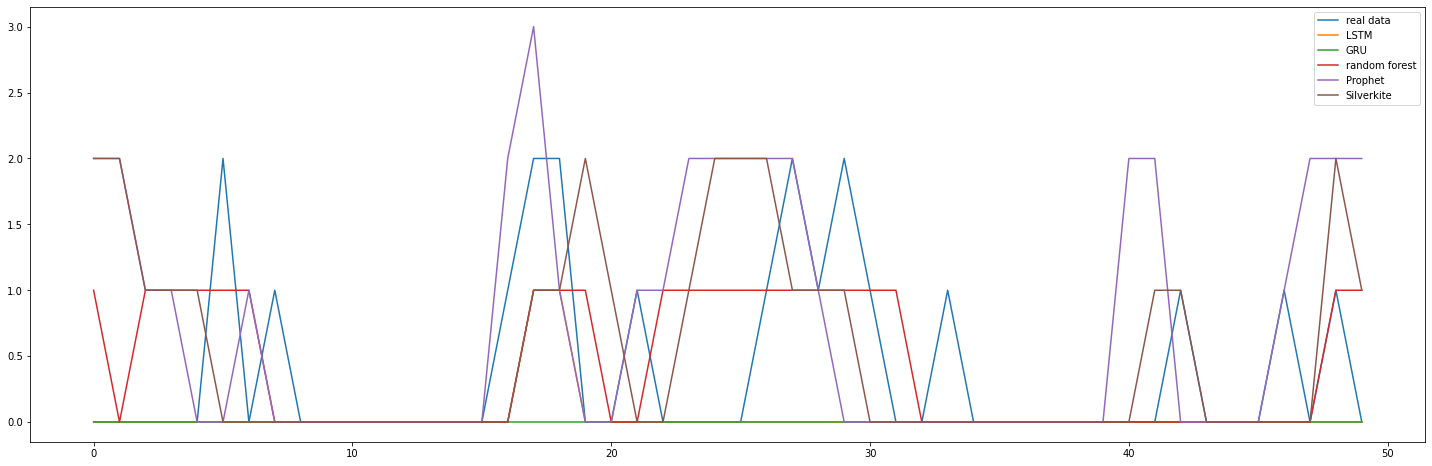

In [69]:
plot_results(551, 'outbound', 300, 50)